### Import Libraries

In [ ]:
# import neccessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from sklearn.model_selection import train_test_split
from keras.layers import Layer
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile

## Data Downloading

In [2]:
# zip_path = "/kaggle/input/digit-recognizer"
# extract_to = "data/"
# # open the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     # extract specific files
#     zip_ref.extract("train.csv", extract_to)
#     zip_ref.extract("test.csv", extract_to)

In [3]:
# take the train data and test data
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

## Data Preprocessing

In [ ]:
# drop the 'label' column from the training dataset and normalize pixel values
X_train = train_data.drop('label', axis=1).values.astype('float32') / 255.0
# extract the 'label' column from the training dataset
y_train = train_data['label'].values

# normalize pixel values
X_test = test_data.values.astype('float32') / 255.0

## Build Model

In [ ]:
class ResidualBlock(layers.Layer):
    def __init__(self, units, dropout_rate=0.3, **kwargs):  # Add **kwargs
        super().__init__(**kwargs)  # Pass kwargs to parent
        self.units = units
        self.dropout_rate = dropout_rate

        # first fully connected layer with GELU activation and L2 regularization
        self.dense1 = layers.Dense(units, activation=activations.gelu, 
                                   kernel_regularizer=regularizers.l2(5e-5))
        
        # dropout layer to prevent overfitting by randomly deactivating neurons during training
        self.dropout1 = layers.Dropout(dropout_rate)

         # second fully connected layer with GELU activation and L2 regularization
        self.dense2 = layers.Dense(units, activation=activations.gelu,
                                 kernel_regularizer=regularizers.l2(5e-5))
        
        # dropout layer to prevent overfitting by randomly deactivating neurons during training
        self.dropout2 = layers.Dropout(dropout_rate)
        
        # layer for element-wise addition (skip connection)
        self.skip_add = layers.Add()

    def call(self, inputs, training=False):
        # forward pass through the first dense and dropout layers
        x = self.dense1(inputs)
        x = self.dropout1(x, training=training)

        # forward pass through the second dense and dropout layers
        x = self.dense2(x)
        x = self.dropout2(x, training=training)

        # add the residual connection: output = x + inputs
        return self.skip_add([x, inputs])

    # allow saving and reloading the layer configuration
    def get_config(self):
        # get the base configuration from the parent class
        config = super().get_config()
        # add custom parameters for serialization
        config.update({
            'units': self.units,
            'dropout_rate': self.dropout_rate
        })
        return config


In [ ]:
def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # initial projection
    x = layers.Dense(1024, activation=None, kernel_regularizer=regularizers.l2(5e-5))(inputs)
    # Batch Normalization
    x = layers.BatchNormalization()(x)
    # use gelu as activation function
    x = layers.Activation(activations.gelu)(x)
    # dropout layer 30%
    x = layers.Dropout(0.3)(x)

    # add residual blocks
    for _ in range(3):  # increase depth
        x = ResidualBlock(1024)(x)

    # final classifier
    # fully connected layer with 256 neurons and GELU activation
    x = layers.Dense(256, activation=activations.gelu)(x) 
    x = layers.Dropout(0.3)(x)
    
    # output layer: fully connected and softmax activation
    outputs = layers.Dense(10, activation='softmax')(x)

    return Model(inputs, outputs)

In [ ]:
# create and compile model with input_shape = 784
model = build_model((784,))

# compile the model with:
# - Adam optimizer: learning rate of 3e-4
# - Sparse categorical crossentropy loss
# - Accuracy metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks using early stopping, model checkpoint and reduceLROnPlateau
# model checkpoint: save the best model (based on validation performance) to a file
# ReduceLROnPlateau: reduce the learning rate by a factor of 0.5 if validation loss 
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]

## Train Model

In [ ]:
history = model.fit(
    X_train, y_train,        # training data (features and labels)
    validation_split=0.2,    # use 20% of training data for validation
    epochs=100,              # train in 100 epochs 
    batch_size=1024,         # number of samples processed before updating model weights
    callbacks=callbacks,     # apply early stopping, learning rate reduction, and model checkpoint
    verbose=1                
)


Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.5924 - loss: 1.8010 - val_accuracy: 0.8648 - val_loss: 1.2381 - learning_rate: 3.0000e-04
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9123 - loss: 0.6331 - val_accuracy: 0.9224 - val_loss: 0.9700 - learning_rate: 3.0000e-04
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9422 - loss: 0.5331 - val_accuracy: 0.9429 - val_loss: 0.7520 - learning_rate: 3.0000e-04
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9559 - loss: 0.4834 - val_accuracy: 0.9565 - val_loss: 0.6047 - learning_rate: 3.0000e-04
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9614 - loss: 0.4605 - val_accuracy: 0.9648 - val_loss: 0.5064 - learning_rate: 3.0000e-04
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9728 - loss: 0.4210 - val_accuracy: 0.9669 - val_loss: 0.4582 - learning_rate: 3.0000e-04
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy

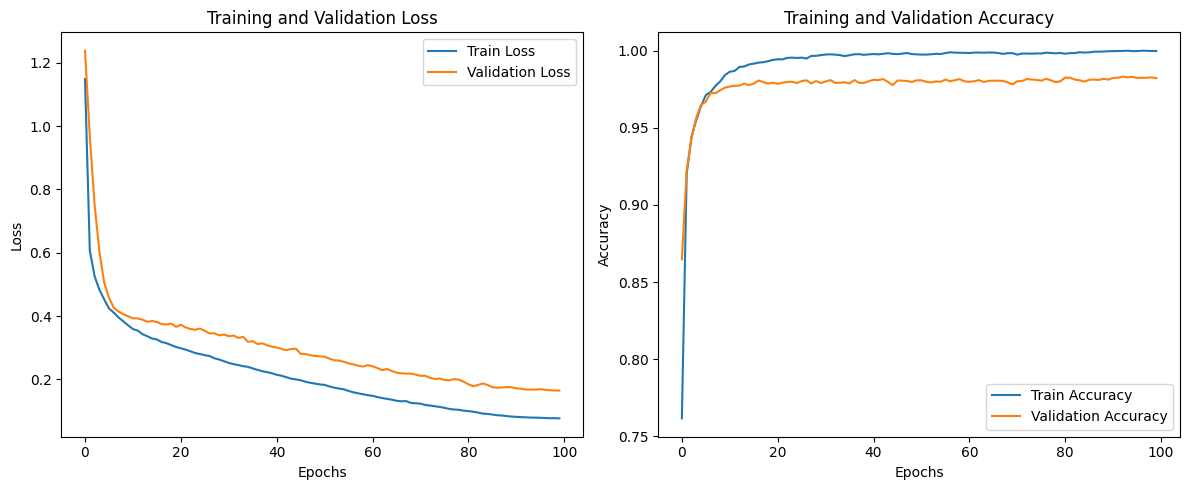

In [ ]:
# plot training history for visualization
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Export CSV file

In [ ]:
model = tf.keras.models.load_model('best_model.keras',
                                 custom_objects={'ResidualBlock': ResidualBlock})

# generate predictions
test_probs = model.predict(X_test)
test_preds = np.argmax(test_probs, axis=1)

# create csv submission file
submission = pd.DataFrame({
    'ImageId': range(1, len(test_preds)+1),
    'Label': test_preds
})
submission.to_csv('submission.csv', index=False)

# print top 5 predictions
print("Submission file created!")
print("Top 5 predictions:")
display(submission.head())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'residual_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'residual_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'residual_block_2', however the la

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Submission file created!
Top 5 predictions:


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [ ]:
# check
print(len(submission))

28000


## Kaggle Submission
#### Link submission: https://drive.google.com/file/d/1tI26VoEg6lOfgZVfCkV0T3H3YPgAXufZ/view?usp=sharing 